In [19]:
import folium
import pandas as pd
import h3
from shapely.geometry import Polygon, Point
import shapely.wkt
from geojson import Point, Feature, FeatureCollection, dump
import os
import matplotlib.pyplot as plt

# Create a GeoJson

### First find all used hexagons

In [20]:
#Get this file from scibo
df = pd.read_csv('sharenow_supply_data_6mo.csv')

df_StartEnd = df[['hex_start_7','hex_end_7']]

list_StartUnique = list(df['hex_start_7'].unique())
list_EndUnique = list(df['hex_end_7'].unique())
list_UniqueHexs = list(pd.Series(list_StartUnique+list_EndUnique).unique())

C:\Users\sbirk\Documents\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Now get the cornerstones

In [21]:
def output_h3_id_attributes(h3_id):
    return Polygon(h3.h3_to_geo_boundary(h3_id, geo_json=True))

In [22]:
features = []
for hexID in list_UniqueHexs:
    features.append(Feature(geometry=output_h3_id_attributes(hexID), properties={"hexID": hexID}))

feature_collection = FeatureCollection(features)

with open('berlin_charger.geojson', 'w') as f:
   dump(feature_collection, f)

# Visulise

In [23]:
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)

In [24]:
chargerPerHex = pd.read_csv('charger_in_hex.csv')
finalData = chargerPerHex[['hexID']]
chargerPerHex = chargerPerHex[['x1','x2','x3']].sum(axis=1)
finalData['charger'] = chargerPerHex

finalData.head(5)

,hexID,charger
0,871f1d4d0ffffff,0.0
1,871f1d48affffff,0.0
2,871f1d48effffff,0.0
3,871f1d499ffffff,5.0
4,871f18b25ffffff,0.0


In [25]:
map.choropleth(geo_data="berlin_charger.geojson",
             data=finalData, 
             columns=['hexID', 'charger'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Charger')
map

C:\Users\sbirk\Documents\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Sensitivities

In [26]:
plt.style.use('seaborn')
figsize = (16,9)

## Opportunity Cost

In [27]:
path = "./sensitivity/opportunity/"
df_charger_opc = pd.DataFrame()
df_E_not_supplied_opc = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_opc = pd.read_csv((path+file))
        df_cost_opc.columns = ["Opportunity Cost", "Total Cost"]
        df_cost_opc.set_index("Opportunity Cost", inplace=True)
        df_cost_opc.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_opc = pd.read_csv((path+file))
        df_cvar_opc.columns = ["Opportunity Cost", "cvar"]
        df_cvar_opc.set_index("Opportunity Cost", inplace=True)
        df_cvar_opc.sort_index(inplace=True)
        
    elif "E_supplied" in file:
        df_E_supplied_opc = pd.read_csv((path+file))
        df_E_supplied_opc.columns = ["Opportunity Cost", "Energy Supplied"]
        df_E_supplied_opc.set_index("Opportunity Cost", inplace=True)
        df_E_supplied_opc.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_opc = pd.read_csv((path+file))
        df_cars_supplied_opc.columns = ["Opportunity Cost", "Cars Supplied"]
        df_cars_supplied_opc.set_index("Opportunity Cost", inplace=True)
        df_cars_supplied_opc.sort_index(inplace=True)

In [28]:
df_cars_supplied_opc

,Cars Supplied
Opportunity Cost,
0.1,0.0
0.2,0.0
0.3,5112.0
0.4,9956.0
0.5,12876.0
0.6,15449.0
0.7,15750.0
0.8,15750.0
0.9,15750.0


In [29]:
df_E_supplied_opc

,Energy Supplied
Opportunity Cost,
0.1,0.0
0.2,0.0
0.3,101947.5
0.4,198324.0
0.5,256374.0
0.6,307975.5
0.7,313614.0
0.8,313614.0
0.9,313614.0


In [30]:
df_opc = pd.DataFrame(df_E_supplied_opc["Energy Supplied"]/df_cars_supplied_opc["Cars Supplied"])
df_opc.columns = ["Energy per car"]
#df_opc.plot(kind="bar")
df_opc

,Energy per car
Opportunity Cost,
0.1,NaN
0.2,NaN
0.3,19.942782
0.4,19.920048
0.5,19.910997
0.6,19.934980
0.7,19.912000
0.8,19.912000
0.9,19.912000


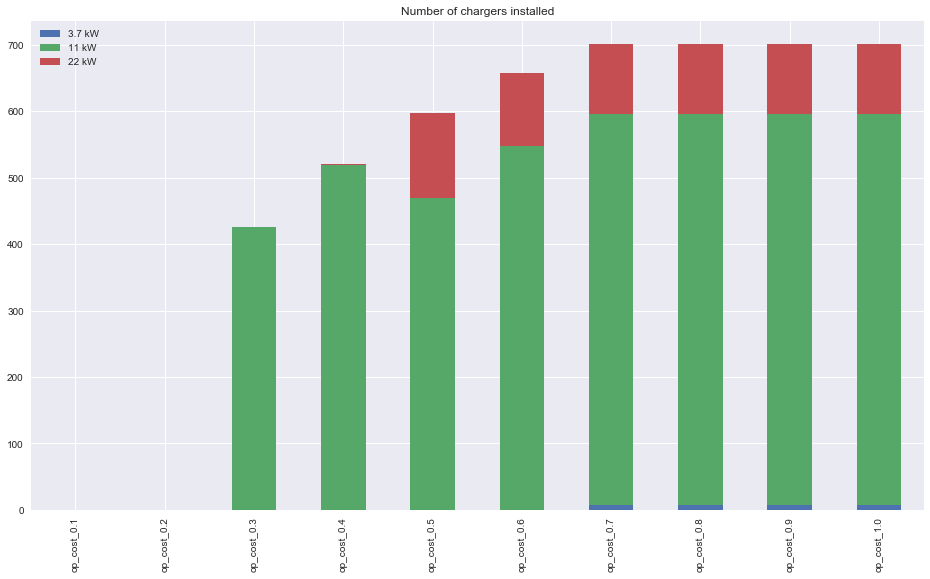

In [92]:
df_charger_opc.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_opc.T.plot(kind="bar", stacked=True, figsize = figsize, title="Number of chargers installed")

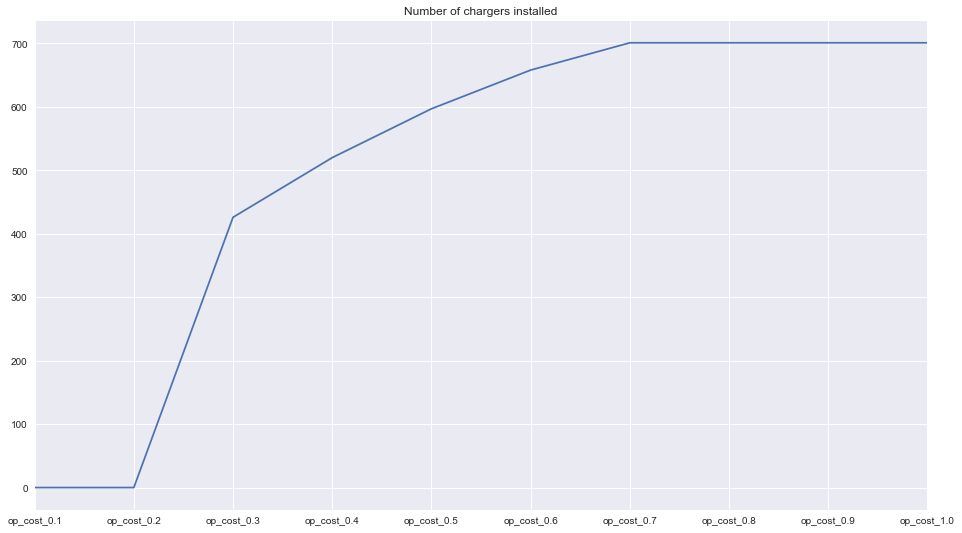

In [65]:
df_charger_opc.sum().plot(figsize = figsize, title="Number of chargers installed")

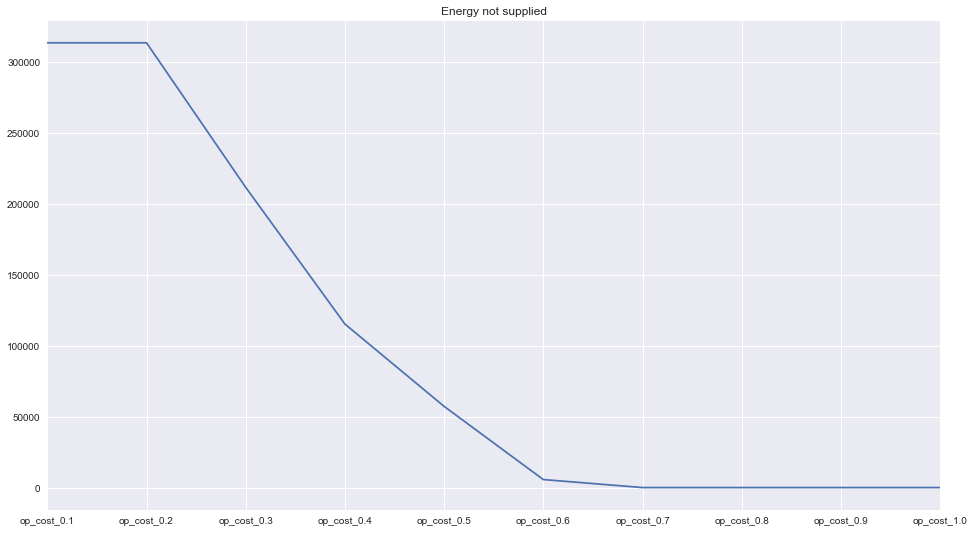

In [32]:
df_E_not_supplied_opc.sum().plot(title="Energy not supplied", figsize = figsize)

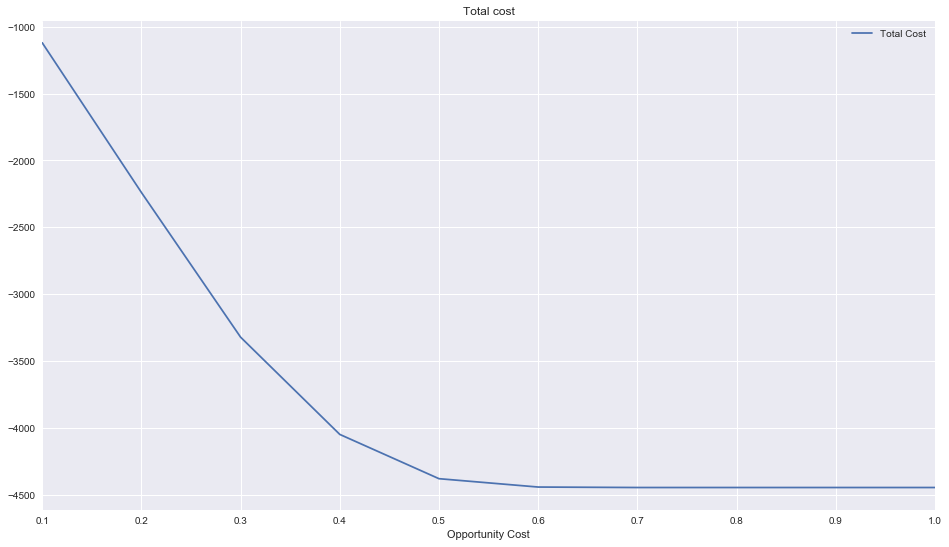

In [33]:
df_cost_opc.plot(title="Total cost", figsize = figsize)

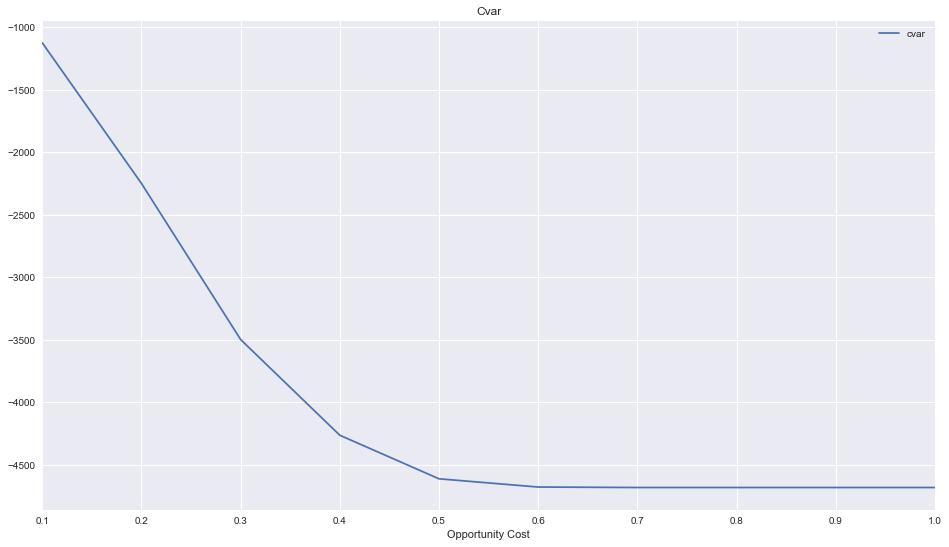

In [34]:
df_cvar_opc.plot(title="Cvar", figsize = figsize)

### Beta

In [67]:
path = "./sensitivity/beta/"
df_charger_beta = pd.DataFrame()
df_E_not_supplied_beta = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_beta = pd.read_csv((path+file))
        df_cost_beta.columns = ["Beta", "Total Cost"]
        df_cost_beta.set_index("Beta", inplace=True)
        df_cost_beta.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_beta = pd.read_csv((path+file))
        df_cvar_beta.columns = ["Beta", "cvar"]
        df_cvar_beta.set_index("Beta", inplace=True)
        df_cvar_beta.sort_index(inplace=True)
        
    elif "E_supplied" in file:
        df_E_supplied_beta = pd.read_csv((path+file))
        df_E_supplied_beta.columns = ["Beta", "Energy Supplied"]
        df_E_supplied_beta.set_index("Beta", inplace=True)
        df_E_supplied_beta.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_beta = pd.read_csv((path+file))
        df_cars_supplied_beta.columns = ["Beta", "Cars Supplied"]
        df_cars_supplied_beta.set_index("Beta", inplace=True)
        df_cars_supplied_beta.sort_index(inplace=True)

In [68]:
df_cars_supplied_beta

,Cars Supplied
Beta,
0.0,15750.0
0.2,15750.0
0.4,15750.0
0.6,15750.0
0.8,15750.0
1.0,15750.0


In [69]:
df_beta = pd.DataFrame(df_E_supplied_beta["Energy Supplied"]/df_cars_supplied_beta["Cars Supplied"])
df_beta.columns = ["Energy per car"]
#df_beta.plot(kind="bar")
df_beta

,Energy per car
Beta,
0.0,19.912
0.2,19.912
0.4,19.912
0.6,19.912
0.8,19.912
1.0,19.912


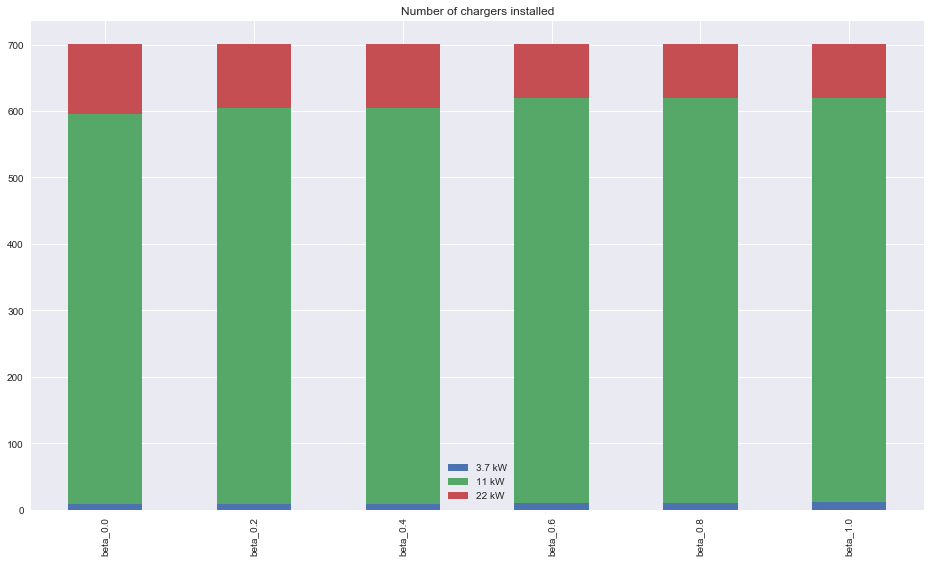

In [91]:
df_charger_beta.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_beta.T.plot(kind="bar", stacked=True, figsize = figsize, title="Number of chargers installed")

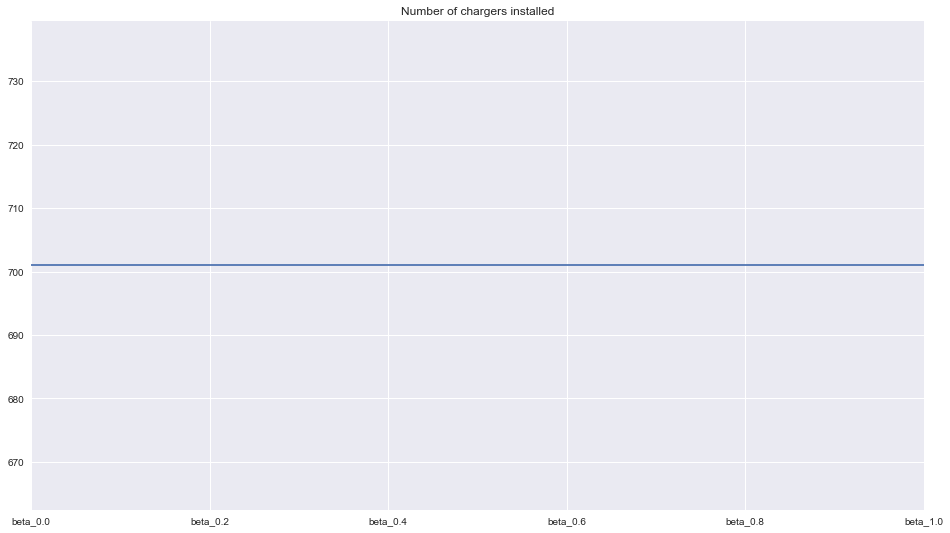

In [71]:
df_charger_beta.sum().plot(figsize = figsize, title="Number of chargers installed")

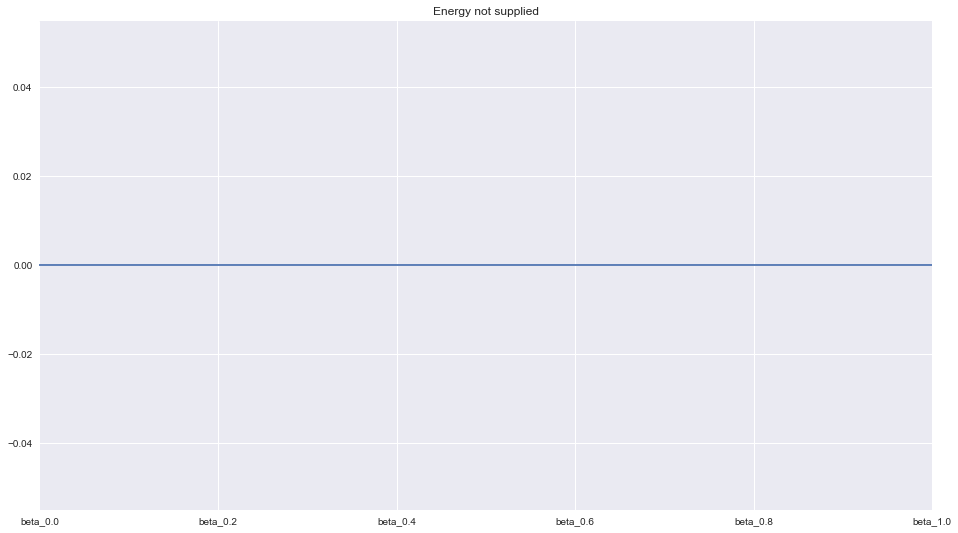

In [72]:
df_E_not_supplied_beta.sum().plot(title="Energy not supplied", figsize = figsize)

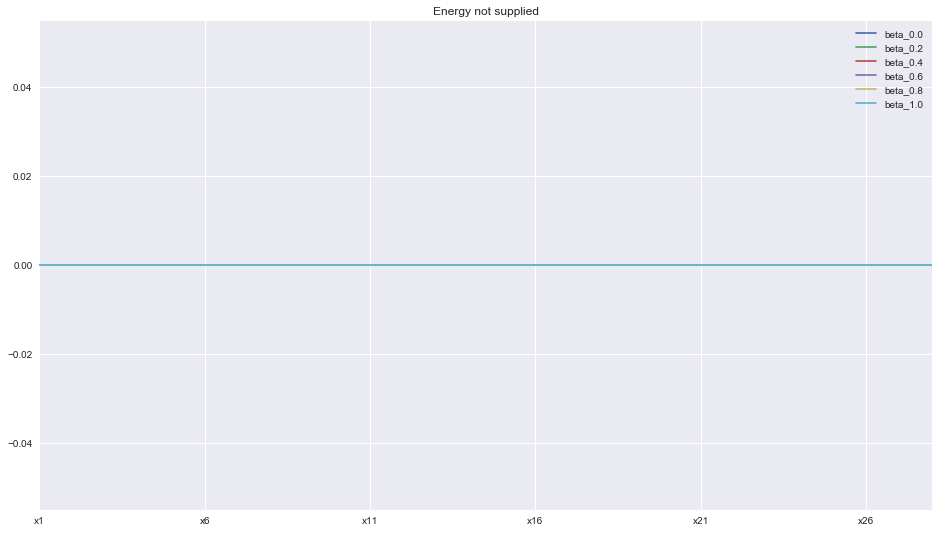

In [73]:
df_E_not_supplied_beta.plot(title="Energy not supplied", figsize = figsize)

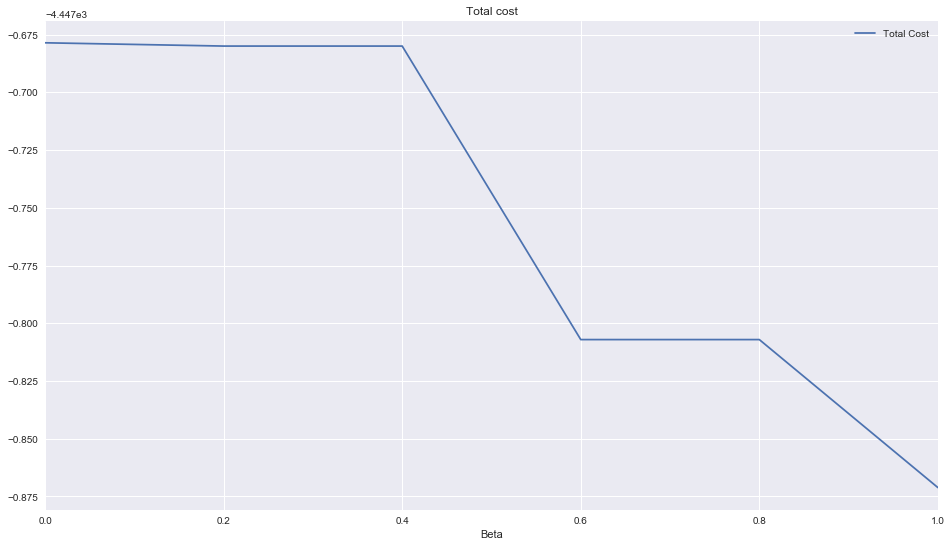

In [74]:
df_cost_beta.plot(title="Total cost", figsize = figsize)

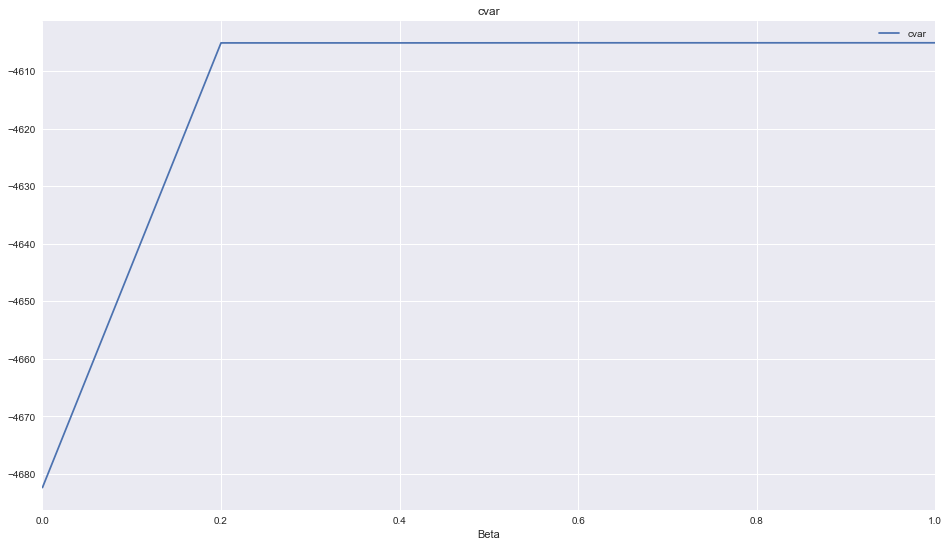

In [75]:
df_cvar_beta.plot(title="cvar", figsize = figsize)

## Charging hours

In [76]:
path = "./sensitivity/hours/"
df_charger_hours = pd.DataFrame()
df_E_not_supplied_hours = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_hours = pd.read_csv((path+file))
        df_cost_hours.columns = ["Hours for charging", "Total Cost"]
        df_cost_hours.set_index("Hours for charging", inplace=True)
        df_cost_hours.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_hours = pd.read_csv((path+file))
        df_cvar_hours.columns = ["Hours for charging", "cvar"]
        df_cvar_hours.set_index("Hours for charging", inplace=True)
        df_cvar_hours.sort_index(inplace=True)
                
    elif "E_supplied" in file:
        df_E_supplied_hours = pd.read_csv((path+file))
        df_E_supplied_hours.columns = ["Hours for charging", "Energy Supplied"]
        df_E_supplied_hours.set_index("Hours for charging", inplace=True)
        df_E_supplied_hours.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_hours = pd.read_csv((path+file))
        df_cars_supplied_hours.columns = ["Hours for charging", "Cars Supplied"]
        df_cars_supplied_hours.set_index("Hours for charging", inplace=True)
        df_cars_supplied_hours.sort_index(inplace=True)

In [77]:
df_hours = pd.DataFrame(df_E_supplied_hours["Energy Supplied"]/df_cars_supplied_hours["Cars Supplied"])
df_hours.columns = ["Energy per car"]
#df_hours.plot(kind="bar")
df_hours

,Energy per car
Hours for charging,
2,19.912
3,19.912
4,19.912
5,19.912
6,19.912
7,19.912


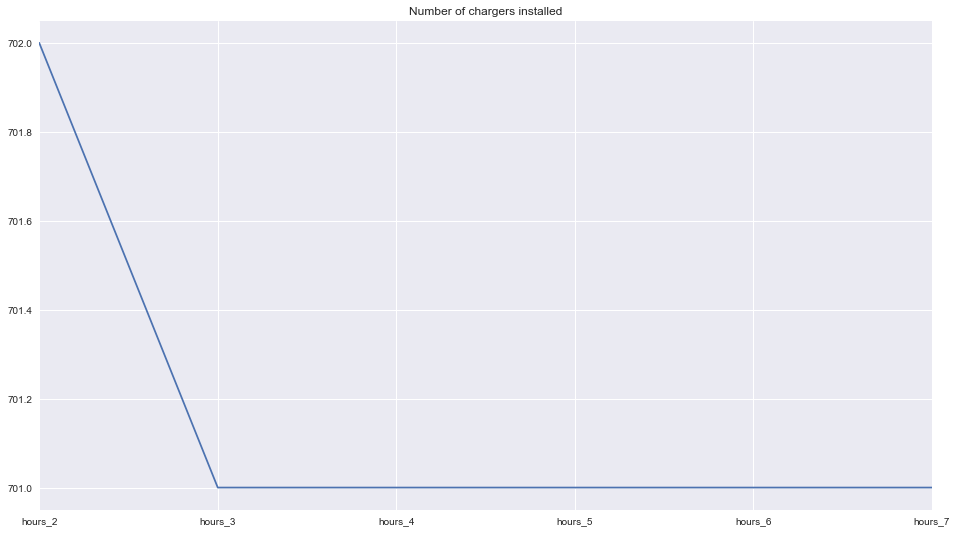

In [83]:
df_charger_hours.sum().plot(title="Number of chargers installed", figsize = figsize)

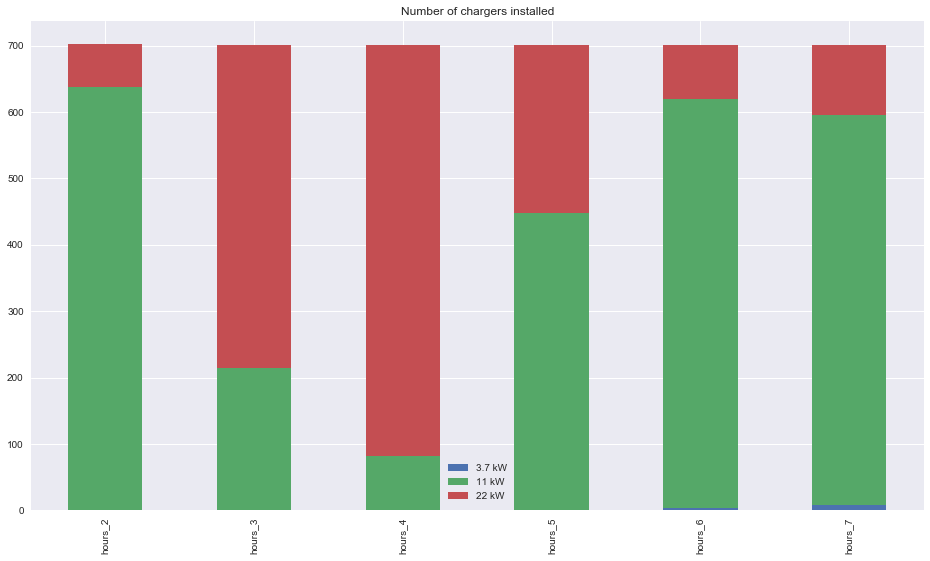

In [90]:
df_charger_hours.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_hours.T.plot(kind="bar", stacked=True, title="Number of chargers installed", figsize = figsize)

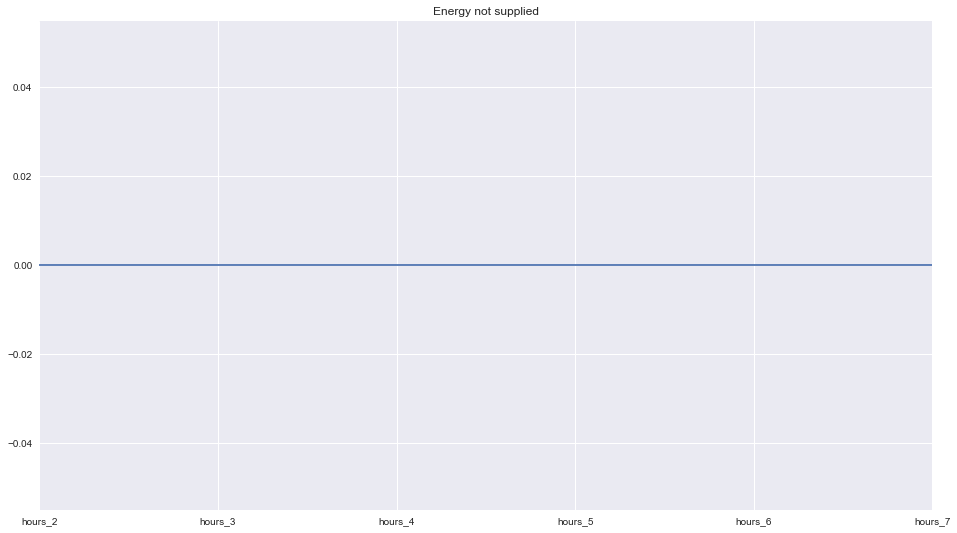

In [79]:
df_E_not_supplied_hours.sum().plot(title="Energy not supplied", figsize = figsize)

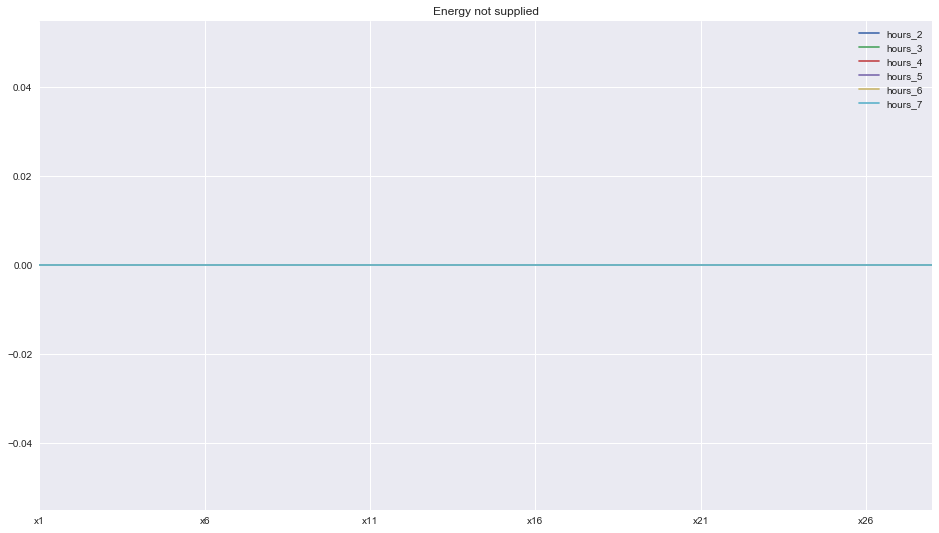

In [80]:
df_E_not_supplied_hours.plot(title="Energy not supplied", figsize = figsize)

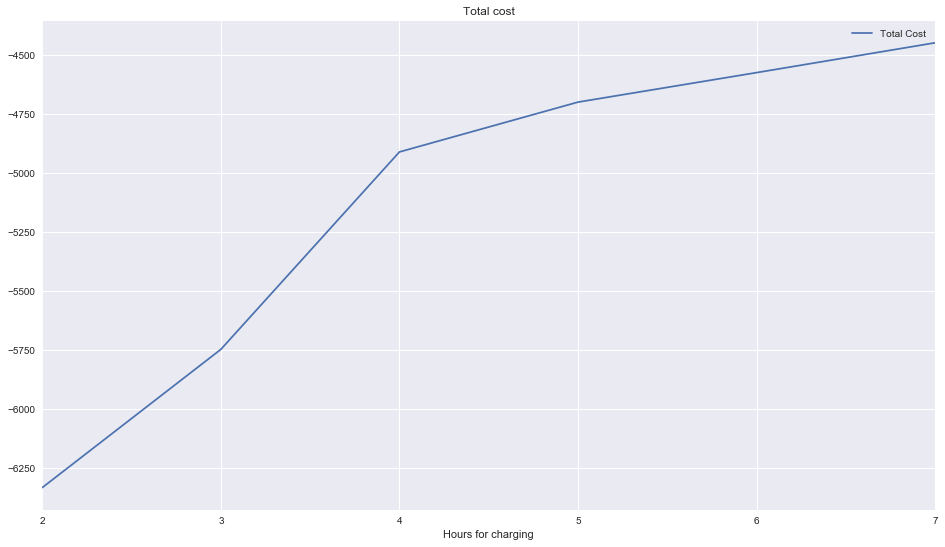

In [81]:
df_cost_hours.plot(title="Total cost", figsize = figsize)

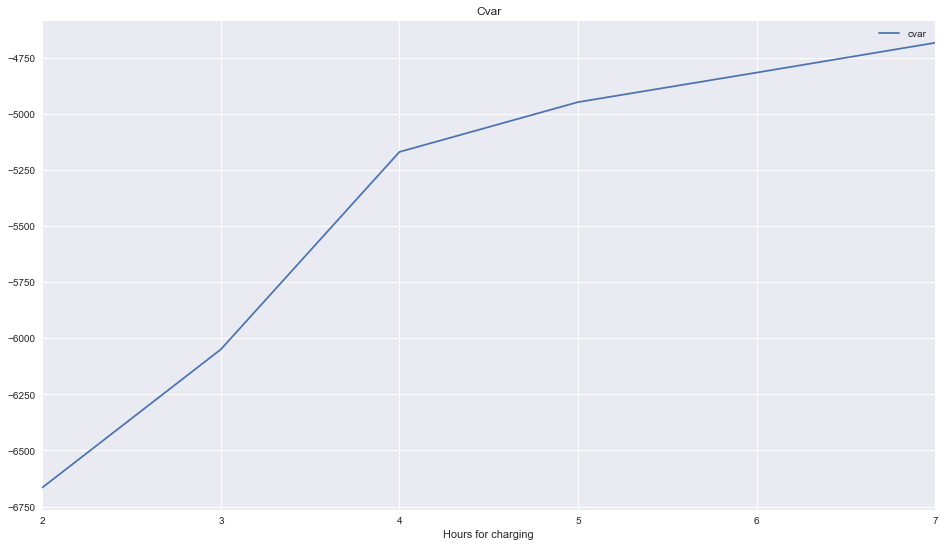

In [82]:
df_cvar_hours.plot(title="Cvar", figsize = figsize)